In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from functools import partial

from src.monte_carlo import GBMMonteCarloSimulation, VarianceReduction, NumericalScheme
from src.black_scholes import price, CallPut

In [3]:
# Setup the experiment constants 

n_sims = list(map(lambda x: 2**x, [1, 2, 3, 4, 5, 6, 7, 8]))  # Number of simulations

S0 = 100                # Initial stock price
r = 0.05                # Risk free rate
sigma = 0.2             # Volatility
T = 0.5                 # Time to maturity
K = 100                 # Strike price
call_put=CallPut.CALL   # Option type
L = 50                  # number of option prices to generate for each n in n_sims  
k = 7                   # number of steps in the simulation 

bs_price = price(S0, K, r, sigma, T, call_put) # Black-Scholes price


In [4]:
# Calculate the option price using the Monte Carlo simulation for the following variance reduction techniques
#  - gaussian (no variance reduction)
#  - antithetic
#  - sobol
#  - brownian_bridge
#  - sobol_brownian_bridge
# Each experiment is run L times

experiment = partial(GBMMonteCarloSimulation, k=k, S0=S0, r=r, sigma=sigma, T=T)
results = defaultdict(lambda: defaultdict(float))

for vr in VarianceReduction:
    for n in n_sims:
        mc_simulator = experiment(n_sims=n)
        results[vr.value][n] = [
            mc_simulator.mc_pricer(
                K, 
                call_put, 
                variance_reduction=vr, 
                numerical_scheme=NumericalScheme.Euler
            ) for _ in range(L)
        ]
    

In [8]:
# Define consistent colours for the plots
colours = {
    'gaussian': 'red',
    'antithetic': 'purple',
    'sobol': 'blue',
    'brownian_bridge': 'orange',
    'sobol_brownian_bridge': 'green'
}


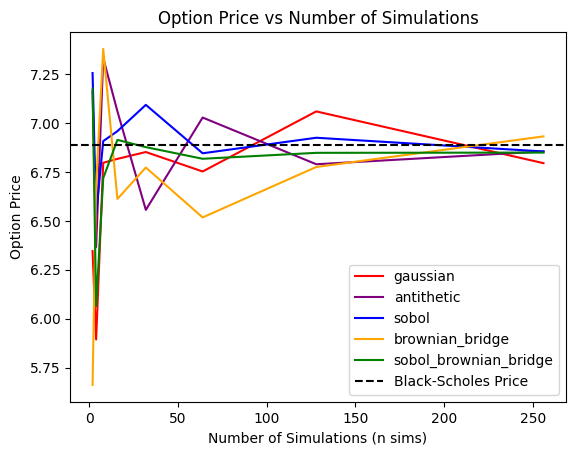

In [10]:
prc_df = pd.DataFrame(
    {vr.value: [np.mean(results[vr.value][n]) for n in n_sims] for vr in VarianceReduction},
    index=n_sims
)

for column in prc_df.columns:
    plt.plot(prc_df.index, prc_df[column], label=column, color=colours[column])

plt.axhline(y=bs_price, color='black', linestyle='--', label='Black-Scholes Price')
plt.xlabel('Number of Simulations (n sims)')
plt.ylabel('Option Price')
plt.title('Option Price vs Number of Simulations')
plt.legend()

In [6]:
# Calculate the RMSE for each variance reduction technique

def rmse(bs_price, mc_estimates):
    return  np.sqrt(1/len(mc_estimates) * np.sum((np.array(mc_estimates) - bs_price)**2))

def _log2_df(df):
    df = pd.DataFrame(_rmse)
    log_df = np.log2(df)
    log_df.index = np.log2(df.index)
    return log_df

_rmse = {
    k: {
        n: rmse(bs_price, v) for n, v in results[k].items()
    } for k in results.keys()
}

rmse_df = pd.DataFrame(_rmse)
rmse_log_df = _log2_df(rmse_df)

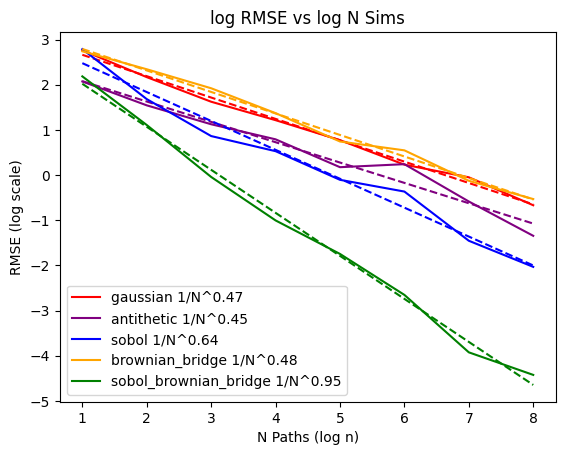

In [11]:
# Plot the RMSE vs N Sims (using a log scale)
trendlines = {}
for column in rmse_log_df.columns:
    trendlines[column] = np.poly1d(np.polyfit(rmse_log_df.index, rmse_log_df[column], 1))

# Plot the data and trendlines
for column in rmse_log_df.columns:
    plt.plot(rmse_log_df.index, rmse_log_df[column], label=f'{column} 1/N^{-1 * trendlines[column][1]:.2f}', color=colours[column], )
    plt.plot(rmse_log_df.index, trendlines[column](rmse_log_df.index), '--', color=colours[column ])

plt.xlabel('N Paths (log n)')
plt.ylabel('RMSE (log scale)')
plt.title('log RMSE vs log N Sims')
plt.legend()
plt.show()